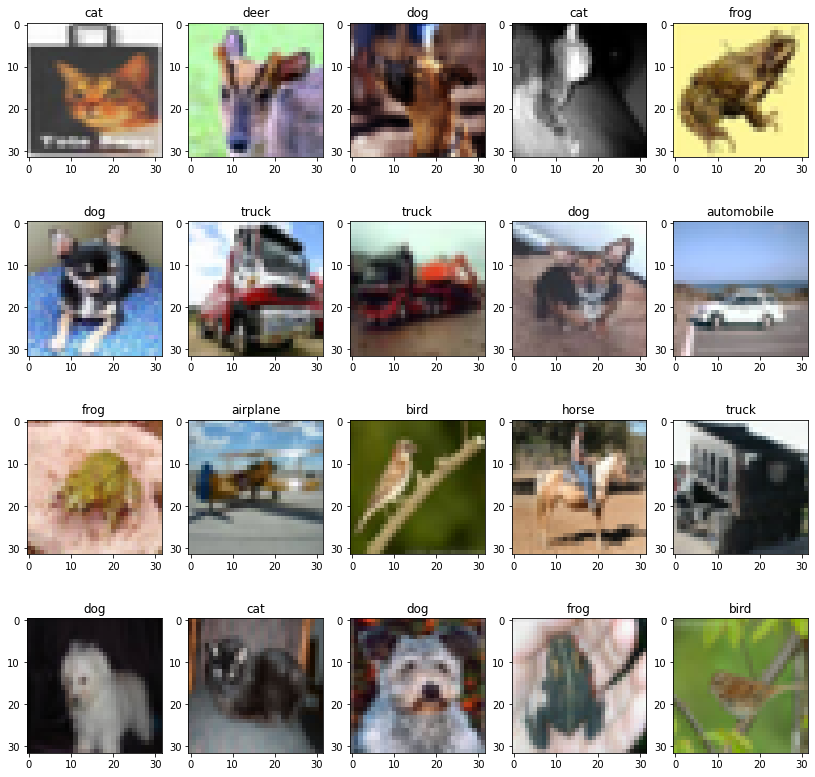

Epoch 1/30
1469/1469 [==============================] - 151s 100ms/step - loss: 1.6134 - sparse_categorical_accuracy: 0.5440 - val_loss: 1.5253 - val_sparse_categorical_accuracy: 0.5707
Epoch 2/30
1469/1469 [==============================] - 150s 102ms/step - loss: 1.0977 - sparse_categorical_accuracy: 0.7183 - val_loss: 1.1961 - val_sparse_categorical_accuracy: 0.6876
Epoch 3/30
1469/1469 [==============================] - 150s 102ms/step - loss: 0.9819 - sparse_categorical_accuracy: 0.7662 - val_loss: 1.2013 - val_sparse_categorical_accuracy: 0.6997
Epoch 4/30
1469/1469 [==============================] - 149s 102ms/step - loss: 0.9297 - sparse_categorical_accuracy: 0.7977 - val_loss: 1.3006 - val_sparse_categorical_accuracy: 0.6883
Epoch 5/30
1469/1469 [==============================] - 149s 101ms/step - loss: 0.8756 - sparse_categorical_accuracy: 0.8225 - val_loss: 1.0707 - val_sparse_categorical_accuracy: 0.7554
Epoch 6/30
1469/1469 [==============================] - 149s 101ms/ste

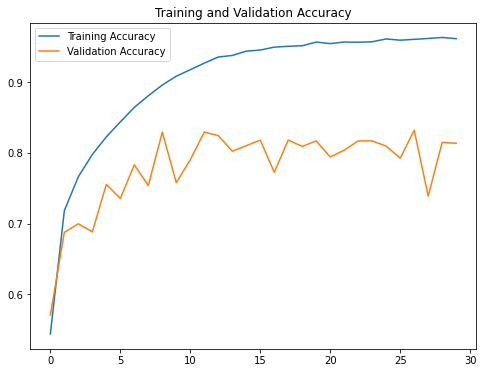

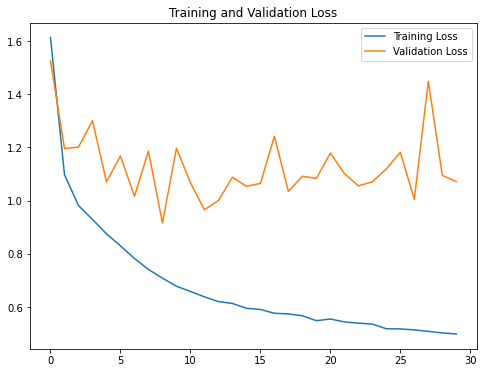

****************************test******************************
313/313 [==============================] - 9s 29ms/step - loss: 1.0721 - sparse_categorical_accuracy: 0.8135

test output
top1 accuracy：0.8134999871253967
top2 accuracy：0.9183


In [ ]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import layers, Sequential, regularizers, datasets
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow import keras
import tensorflow.keras.preprocessing.image as image

np.set_printoptions(threshold=np.inf)
# preprocessing
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data() 

# cifar10 = tf.keras.datasets.cifar10
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# dataset segmentation
x_valid, x_train = x_train[:3000], x_train[3000:]
y_valid, y_train = y_train[:3000], y_train[3000:]


# data displaying
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(14, 14))
# Displays the first 20 images and displays categories on the image
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.grid(False)
    plt.imshow(x_train[i, :, :, ], cmap=plt.cm.binary)
    plt.rcParams['font.sans-serif'] = ['SimHei']  
    t = labels[y_train[i][0]]
    plt.title(t)
plt.show()


class ResnetBlock(Model):

    def __init__(self, filters, strides=1, residual_path=False):
        super(ResnetBlock, self).__init__()
        self.filters = filters
        self.strides = strides
        self.residual_path = residual_path

        self.c1 = Conv2D(filters, (3, 3), strides=strides, padding='same',
                         kernel_regularizer=regularizers.l2(5e-5), use_bias=False, kernel_initializer='glorot_normal')
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        self.c2 = Conv2D(filters, (3, 3), strides=1, padding='same',
                         kernel_regularizer=regularizers.l2(5e-5), use_bias=False, kernel_initializer='glorot_normal')
        self.b2 = BatchNormalization()

        # when residual_path is True，Downsample the input, 
        # use a 1x1 convolution kernel for the convolution operation to ensure that x can be the same dimension as F(x)
        if residual_path:
            self.down_c1 = Conv2D(filters, (1, 1), strides=strides, padding='same',
                                  kernel_regularizer=regularizers.l2(5e-5), use_bias=False,
                                  kernel_initializer='glorot_normal')
            self.down_b1 = BatchNormalization()

        self.a2 = Activation('relu')

    def call(self, inputs):
        residual = inputs  # residual=x
        # F(x) = Input(Conv + BN + Relu) 
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)

        x = self.c2(x)
        y = self.b2(x)

        if self.residual_path:
            residual = self.down_c1(inputs)
            residual = self.down_b1(residual)

        out = self.a2(y + residual)  # output = Relu(F(x) + x)
        return out


class ResNet18(Model):

    def __init__(self, block_list, initial_filters=64): # block list: [2, 2, 2, 2]
        super(ResNet18, self).__init__()
        self.num_blocks = len(block_list) 
        self.block_list = block_list
        self.out_filters = initial_filters
        self.c1 = Conv2D(self.out_filters, (3, 3), strides=1, padding='same', use_bias=False)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')
        self.blocks = tf.keras.models.Sequential()
        # construct ResNet block
        for block_id in range(len(block_list)):  # resnet block number
            for layer_id in range(block_list[block_id]):  # convolution layer number

                if block_id != 0 and layer_id == 0:  # Downsamples each block except the first one
                    block = ResnetBlock(self.out_filters, strides=2, residual_path=True)
                else:
                    block = ResnetBlock(self.out_filters, residual_path=False)
                self.blocks.add(block)  # add block to resnet
            self.out_filters *= 2
        self.p1 = tf.keras.layers.GlobalAveragePooling2D()
        self.f1 = tf.keras.layers.Dense(10, activation='softmax',
                                        kernel_regularizer=tf.keras.regularizers.l2())

    def call(self, inputs):
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)
        x = self.blocks(x)
        x = self.p1(x)
        y = self.f1(x)
        return y


# model training
def model_train(x_train, y_train, x_valid, y_valid):
    model = ResNet18([2, 2, 2, 2])
    save_path = 'resnet18.h5'

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['sparse_categorical_accuracy'])

    checkpoint_save_path = "ResNet18.ckpt"
    if os.path.exists(checkpoint_save_path + '.index'):
        print('-------------load the model-----------------')
        model.load_weights(checkpoint_save_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                     save_weights_only=True,
                                                     save_best_only=True)

    tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./model', histogram_freq=1, write_grads=True)
    history = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_valid, y_valid),
                        validation_freq=1,
                        callbacks=[tensorboard])
    model.summary()

    # save weight
    file = open('./weights.txt', 'w')
    for v in model.trainable_variables:
        file.write(str(v.name) + '\n')
        file.write(str(v.shape) + '\n')
        file.write(str(v.numpy()) + '\n')
    file.close()

    return history, model


###############################################    show   ###############################################
# 数据可视化
def figshow(history):
    # Displays acc and Loss curves for training sets and validation sets
    print('\n\n\n')
    print('----------------------------------------------plot figure-------------------------------------')
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.subplots(figsize=(8, 6))
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.subplots(figsize=(8, 6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


# Testing
def data_test(x_test, y_test, model):
    print('****************************test******************************')
    loss, acc = model.evaluate(x_test, y_test)
    top1_acc = acc

    # print("test_accuracy:{:5.2f}%".format(100 * acc))
    y_pred = model.predict(x_test)
    k_b = tf.math.top_k(y_pred, 2).indices
    idx = 0
    acc = 0.0
    for i in k_b:
        if y_test[idx] in i.numpy():
            acc = acc + 1
        idx = idx + 1
    top2_acc = acc / y_test.shape[0]
    print('\ntest output')
    print('top1 accuracy：{0}\ntop2 accuracy：{1}'.format(top1_acc, top2_acc))
    return top1_acc, top2_acc


if __name__ == '__main__':
    # train
    history, model = model_train(x_train, y_train, x_test, y_test)
    figshow(history)

    # test
    data_test(x_test, y_test, model)


# New Section